필요한 패키지를 로드합니다.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
import seaborn as sns

/Users/rickypark/anaconda/envs/tfk-notebooks/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


1000개의 데이터를 난수로 생성합니다. 대략 절반 정도는 평균:0.5, 표준편차:0.6의 x값과 평균:0.3, 표준편차:0.9의 y값을 가지고 나머지 절만 정도는 평균:2.5, 표준편차:0.4의 x값과 평균:0.8, 표준편차:0.5의 y값을 가집니다.

In [3]:
num_vectors = 1000
num_clusters = 3
num_steps = 100
vector_values = []
for i in range(num_vectors):
  if np.random.random() > 0.5:
    vector_values.append([np.random.normal(0.5, 0.6),
                          np.random.normal(0.3, 0.9)])
  else:
    vector_values.append([np.random.normal(2.5, 0.4),
                         np.random.normal(0.8, 0.5)])

vector_values 의 2차원 배열의 값을 각각 데이터프레임의 컬럼으로 지정합니다. 시본으로 그래프를 그립니다.

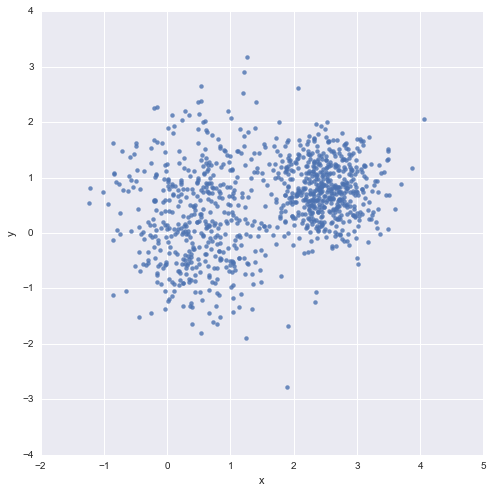

In [4]:
df = pd.DataFrame({"x": [v[0] for v in vector_values], 
                   "y": [v[1] for v in vector_values]})
sns.lmplot("x", "y", data=df, fit_reg=False, size=7)
plt.show()

vector_values를 사용하여 constant를 만들고 초기 센트로이드 세개를 랜덤하게 선택합니다. 그런 후에 vectors, centroids 텐서에 각각 차원을 추가합니다.

In [5]:
vectors = tf.constant(vector_values)
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0], [num_clusters,-1]))
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroids = tf.expand_dims(centroids, 1)

print(expanded_vectors.get_shape())
print(expanded_centroids.get_shape())

(1, 1000, 2)
(3, 1, 2)


각 데이터 포인트에서 가장 가까운 센트로이드의 인덱스를 계산합니다.

In [6]:
distances = tf.reduce_sum(tf.square(tf.sub(expanded_vectors, expanded_centroids)), 2)
assignments = tf.argmin(distances, 0)

각 클러스터의 평균 값을 계산하여 새로운 센트로이드를 구합니다.

In [7]:
means = tf.concat(0, [
  tf.reduce_mean(
      tf.gather(vectors, 
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1])
  for c in range(num_clusters)])

update_centroids = tf.assign(centroids, means)

변수를 초기화하고 세션을 시작합니다.

In [8]:
init_op = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init_op)

100번의 반복을 하여 센트로이드를 계산하고 결과를 출력합니다.

In [9]:
for step in range(num_steps):
   _, centroid_values, assignment_values = sess.run([update_centroids, centroids, assignments])

print("centroids")
print(centroid_values)

centroids
[[ 0.51565474 -0.4095217 ]
 [ 0.41986006  1.1198951 ]
 [ 2.49510527  0.79939651]]


vector_values 데이터를 클러스터에 따라 색깔을 구분하여 산포도를 그립니다.

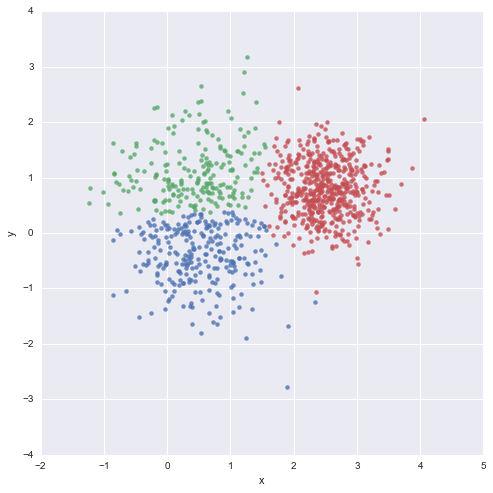

In [10]:
data = {"x": [], "y": [], "cluster": []}
for i in range(len(assignment_values)):
    data["x"].append(vector_values[i][0])
    data["y"].append(vector_values[i][1])
    data["cluster"].append(assignment_values[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, 
           fit_reg=False, size=7, 
           hue="cluster", legend=False)
plt.show()